---
# Part 2, Figure 9
Plot spill locations relavent to regional impact.
**I broke this code when tidying up for publication and need to fix**

---

Spill files generated on [Digital Research Alliance of Canada](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://alliancecan.ca/en&ved=2ahUKEwi5npbTx86OAxU-CTQIHbQPDOsQFnoECA8QAQ&usg=AOvVaw08Yp1H1fiIsvct5I2kJu1_) HPC using `spillLocationsByImpactRegion.ipynb` have been archived in `aggregated_spills_output/SpillLocationImpacts`  folder of [FRDR data repository](https://doi.org/10.20383/103.01353).

```
$ conda env create -f ./environment.yaml
```
                                                                               
To activate this environment, use 
```                  
$ conda activate midoss_env
```
 To deactivate an active environment, use
```
$ conda deactivate
```

Files are loaded from the dataset archive, with both the dataset archive and this code archive in the same folder, i.e.:

- \path\to\root\folder\
   - MuellerEtAl_MIDOSS_datasets
   - MuellerEtAl_MIDOSS_code [this repository]


In [1]:
import os
import sys
from pathlib import Path
import yaml
import numpy
import pandas
import xarray 
import netCDF4 as nc
from cartopy import crs,feature
#import h5netcdf
from datetime import datetime
from datetime import date
from glob import glob
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, patches, colors
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText

In [2]:
# mapping specifications
import cartopy
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

In [3]:
# define directory paths
graphics_directory = Path('../')

# Aggregated spills files (created on Digital Alliance HPC)
spill_file_dir = Path('../../MuellerEtAl_MIDOSS_datasets/aggregated_spills_output/SpillLocationImpacts')

# SalishSeaCast shoreline mask and grid
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV21-08")
mask = mesh_mask.tmaskutil
lons,lats = numpy.squeeze(mesh_mask.glamt), numpy.squeeze(mesh_mask.gphit)


# bathy = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV21-08")
# lons,lats = bathy.longitude, bathy.latitude

# grid_dir = Path('../../../../Data/SalishSeaCast/grid')
# coords = xarray.open_dataset(grid_dir/'coordinates_seagrid_SalishSea201702.nc', decode_times=False)
#lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]
#lats = mask['nav_lat'][1:-1,1:-1]
#lons = mask['nav_lon'][:]

lons.shape

(898, 398)

In [5]:
spill_files = [file for file in os.listdir(spill_file_dir) if file.endswith(".yaml")]
locs = [filename.split('_')[0] for filename in spill_files]
loc_tags=list(set(locs))
liters_to_gal = 0.264172 * 1e-6

print(spill_files)
# spill_files = [
#  'cwchn_NONESpillLocations.yaml',
#  'cwchn_SpillLocations.yaml',
#  'jdf_NONESpillLocations.yaml',
#  'jdf_SpillLocations.yaml',
#  'lummi_NONESpillLocations.yaml',
#  'lummi_SpillLocations.yaml',
#  'sji_NONESpillLocations.yaml',
#  'sji_SpillLocations.yaml']


['sji_SpillLocations.yaml', 'jdf_SpillLocations.yaml', 'ps_SpillLocations.yaml', 'ps_NONESpillLocations.yaml', 'sji_NONESpillLocations.yaml', 'sog_SpillLocations.yaml', 'sog_NONESpillLocations.yaml', 'cwchn_SpillLocations.yaml', 'lummi_SpillLocations.yaml', 'jdf_NONESpillLocations.yaml', 'cwchn_NONESpillLocations.yaml', 'lummi_NONESpillLocations.yaml']


In [6]:
spillLocsByRegion={}
no_spillLocsByRegion={}
max_vol=0
for loc in loc_tags:
    with open(spill_file_dir/f"{loc}_SpillLocations.yaml", 'r') as file:
        spillLocsByRegion[loc] = yaml.safe_load(file)
    with open(spill_file_dir/f"{loc}_NONESpillLocations.yaml", 'r') as file:
        no_spillLocsByRegion[loc] = yaml.safe_load(file)
    max_vol=max(numpy.max(spillLocsByRegion[loc]['vol']),max_vol)
    max_vol=max(numpy.max(no_spillLocsByRegion[loc]['vol']),max_vol)

In [7]:
# grid cell locations [y-grid,x-grid]
grid_dir = Path('../../../../Data/SalishSeaCast/grid')
mask = xarray.open_dataset(grid_dir/'mesh_mask201702.nc')
bathy = xarray.open_dataset(grid_dir/'bathymetry_201702.nc')
coords = xarray.open_dataset(grid_dir/'coordinates_seagrid_SalishSea201702.nc', decode_times=False)
lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]
lats = mask['nav_lat'][1:-1,1:-1]
lons = mask['nav_lon'][:]
lats.shape

(896, 396)

In [8]:
# General regional interests
# Juan de Fuca
JDF = numpy.full(lons.shape, True)
JDF[225:475,0:170] = False
JDF_masked = numpy.ma.masked_where(JDF, numpy.ones(lons.shape))

# box method
jdf_edges=[[225,0],[225,173],[475,173],[475,0]]
jdf_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in jdf_edges])

# Puget Sound
PS = numpy.full(lons.shape, True)
PS[0:160,50:325] = False
PS_masked = numpy.ma.masked_where(PS, numpy.ones(lons.shape))

# box method
ps_edges=[[0,50],[0,325],[215,325],[215,50]]
ps_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in ps_edges])

# Strait of Georgia
SOG = numpy.full(lons.shape, True)
SOG[335:715,100:-1] = False
SOG_masked = numpy.ma.masked_where(SOG, numpy.ones(lons.shape))

# box method
SOG_edges=[[335,100],[335,-1],[715,-1],[715,100]]
sog_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in SOG_edges])

# Areas of import to two Coast Salish communities
# Cowichan
cwchn = numpy.full(lons.shape, True)
cwchn[340:500,150:295] = False
cwchn_masked = numpy.ma.masked_where(cwchn, numpy.ones(lons.shape))

# box method
cwchn_edges=[[340,150],[340,295],[500,295],[500,150]]
cwchn_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in cwchn_edges])

# SJI
sji = numpy.full(lons.shape, True)
sji[274:324,237:270] = False
sji_masked = numpy.ma.masked_where(sji, numpy.ones(lons.shape))

# box method
sji_edges=[[274,237],[274,270],[324,270],[324,237]]
sji_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in sji_edges])

# Lummi
lummi = numpy.full(lons.shape, True)
lummi[300:325,338:370] = False
lummi_masked = numpy.ma.masked_where(lummi, numpy.ones(lons.shape))

# box method
lummi_edges=[[300,338],[300,370],[325,370],[325,338]]
lummi_box = numpy.array([[lons[edge[0],edge[1]],lats[edge[0],edge[1]]] for edge in lummi_edges])

# megaliters

In [9]:
loc_tags = ['lummi', 'jdf', 'cwchn', 'sji']
# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

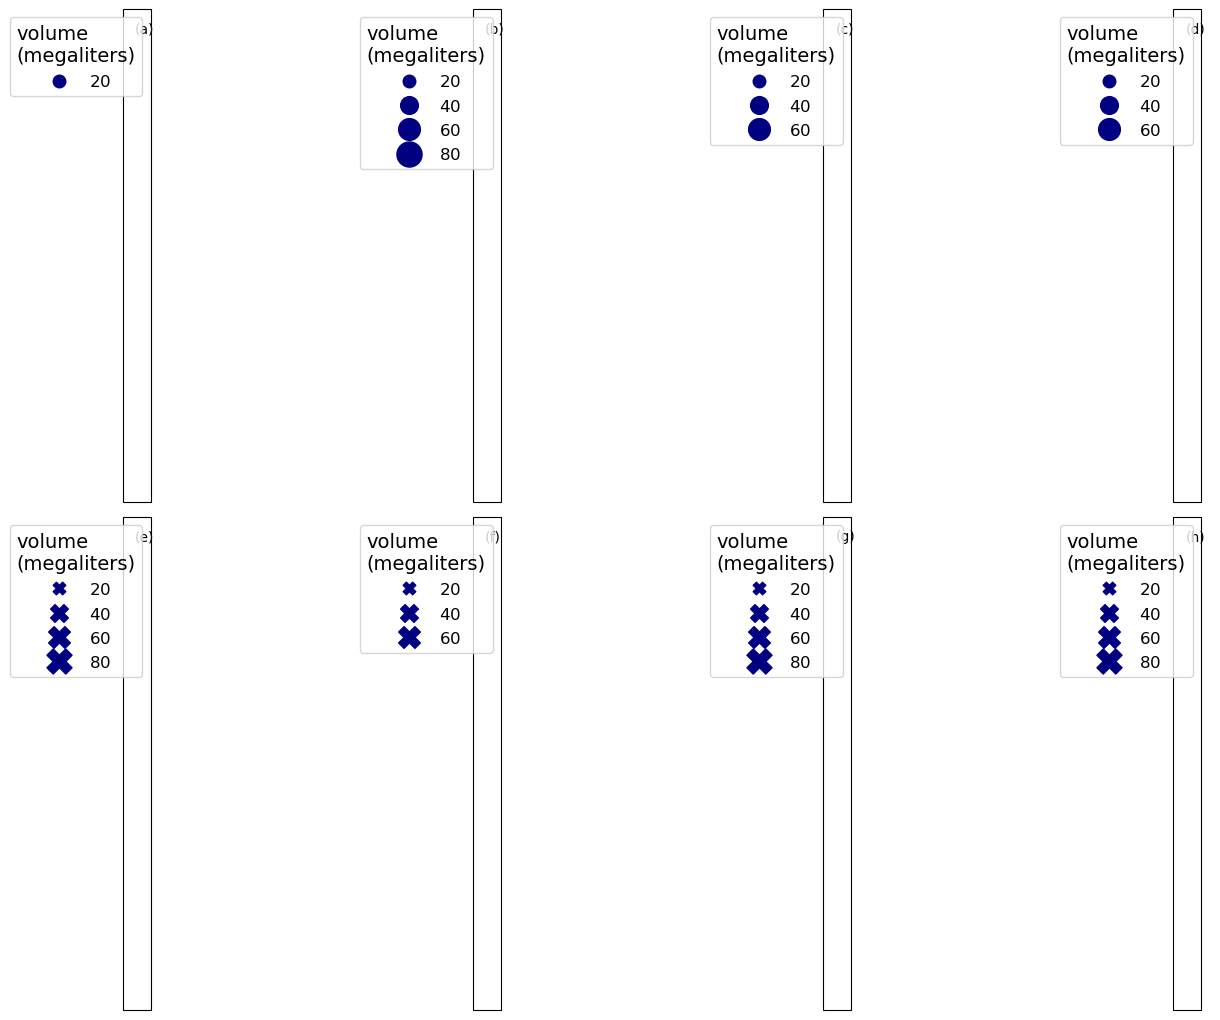

In [10]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fs_legend = 12
fs_legend_title = 14
# scale for scatter plot marker size
ms=400

fig, axs = plt.subplots(2, 4, 
              figsize=(18, 13), #(width, height)
              subplot_kw={'projection': rotated_crs, 
                "facecolor": "white"},
              gridspec_kw={
                   'width_ratios': [1,1,1,1],
                   'height_ratios': [1,1],
                   'wspace': 0.015,
                  'hspace': 0.03}
)
for idx,region in enumerate(loc_tags):#['sji','ps','lummi']:
    # --------- Figure setup ---------
    proj_ref = crs.PlateCarree()
    lw = 1 # linewidth for regional boundary boxes
    fs = 12 #fontsize for colorbar

    for subplot in [0,1]:
        # Make map
        extent = [-126.5, -121.2, 46.8, 51.2]
        proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
        axs[subplot,idx].set_extent([-124, -123.75, lats.min()-0.15, lats.max()])      
        axs[subplot,idx].add_feature(feature.GSHHSFeature(
            'full', edgecolor='grey', linewidth=0.6, facecolor='papayawhip'))
        axs[subplot,idx].add_feature(feature.NaturalEarthFeature(
            category='physical', name='rivers_lake_centerlines',
            scale='10m', facecolor='none', edgecolor='grey')
        )
        
        # add lat/lon lines
        if (idx == 0) and (subplot == 1):
            gl = axs[subplot,idx].gridlines(linestyle="--", color='gray', alpha=0.5, draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.top_labels, gl.right_labels = False, False
        else:
            gl = axs[subplot,idx].gridlines(linestyle="--", color='gray', alpha=0.5, draw_labels=False, dms=True, x_inline=False, y_inline=False)
       
        # ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.xlocator = mticker.FixedLocator([-126, -125, -124, -123, -122])
        gl.ylocator = mticker.FixedLocator([47,48,49,50])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 12, 'color': 'gray'}
        gl.ylabel_style = {'size': 12, 'color': 'gray'}

        # Overlay region box
        domain_box = numpy.array(
            [(lons[ji], lats[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
        #c=axs[0].contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
        p=axs[subplot,idx].add_patch(patches.Polygon(locals()[f'{region}_box'], fc='w', ec='k', alpha=0.2, lw=lw, transform=proj_ref, zorder=3))
        p=axs[subplot,idx].add_patch(patches.Polygon(locals()[f'{region}_box'], fc='none', ec='darkred', lw=3, transform=proj_ref, zorder=3))


        # ~~~ Number of spills ~~~
        if subplot==0:
            spill_color = 'navy'
            # do coordinate conversion of (x,y)
            xynps = axs[subplot,idx].projection.transform_points(
                crs.Geodetic(), 
                numpy.array(spillLocsByRegion[region]['lon']), 
                numpy.array(spillLocsByRegion[region]['lat']))
            # calculate histograms for number of spills and plot using pcolormesh
            s = [ms*vol/max_vol for vol in spillLocsByRegion[region]['vol']]
            scatter_transfers=axs[subplot,idx].scatter(
                xynps[:,0], 
                xynps[:,1],
                color=spill_color,
                marker='o',
                zorder=4,
                s=s,
                alpha=0.5
            )
            # use "func" to convert values back and scale from liters to megaliters
            # see: https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
            handles, labels = scatter_transfers.legend_elements(
                prop="sizes", color=spill_color, num=[20,40,60,80], func=lambda x: max_vol*x/400/1000,alpha=1)
            legend = axs[subplot,idx].legend(
                handles, 
                labels, 
                loc="upper right", 
                title="volume\n(megaliters)", 
                fontsize=fs_legend)
             # add text with ship type
            subplot_label = AnchoredText(
                subplot_labels[idx], 
                loc="upper left",frameon=False
            )
            axs[subplot,idx].add_artist(subplot_label)
            plt.setp(legend.get_title(),fontsize=fs_legend_title)
            #axs[subplot,idx].set_title(f'Affecting\n{region.upper()} Coastline', fontsize=fs)
        else:
            # do coordinate conversion of (x,y)
            nospill_color = 'navy'
            xynps = axs[subplot,idx].projection.transform_points(
                crs.Geodetic(), 
                numpy.array(no_spillLocsByRegion[region]['lon']), 
                numpy.array(no_spillLocsByRegion[region]['lat']))
             # calculate histograms for number of spills and plot using pcolormesh
            s = [ms*vol/max_vol for vol in no_spillLocsByRegion[region]['vol']]
            scatter_transfers=axs[subplot,idx].scatter(
                xynps[:,0], 
                xynps[:,1],
                color=nospill_color,
                edgecolor=nospill_color,
                marker='X',
                zorder=4,
                s=s,
                alpha=0.5
            )
            # use "func" to convert values back and scale from liters to megaliters
            # see: https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
            handles, labels = scatter_transfers.legend_elements(
                prop="sizes", color=spill_color, 
                num=[20,40,60,80], 
                func=lambda x: max_vol*x/400/1000,
                alpha=1)

            # handles, labels = scatter_transfers.legend_elements(
            #     prop="sizes", color=nospill_color, num=4, alpha=1)
            legend = axs[subplot,idx].legend(
                handles, 
                labels, 
                loc="upper right", 
                title="volume\n(megaliters)", 
                fontsize=fs_legend)
            # add text with ship type
            subplot_label = AnchoredText(
                subplot_labels[4+idx], 
                loc="upper left",frameon=False
            )
            axs[subplot,idx].add_artist(subplot_label)
            plt.setp(legend.get_title(),fontsize=fs_legend_title)
            #axs[subplot,idx].set_title(f'Not Affecting\n{region.upper()} Coastline', fontsize=fs)
   
plt.savefig(graphics_directory/f'Figure15_Spills_vs_NoSpills_byRegion_Mliters.png')
    

# millions of gallons

[<matplotlib.lines.Line2D object at 0x15119aad0>, <matplotlib.lines.Line2D object at 0x15119ac10>, <matplotlib.lines.Line2D object at 0x15119ad50>, <matplotlib.lines.Line2D object at 0x15119ae90>]
[<matplotlib.lines.Line2D object at 0x1535eaad0>, <matplotlib.lines.Line2D object at 0x1535eac10>, <matplotlib.lines.Line2D object at 0x1535ead50>, <matplotlib.lines.Line2D object at 0x1535eae90>]


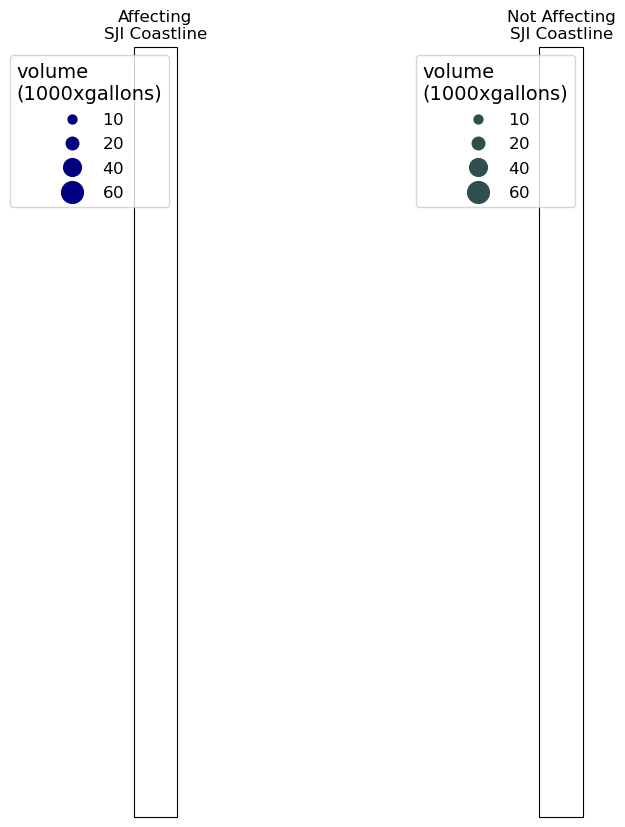

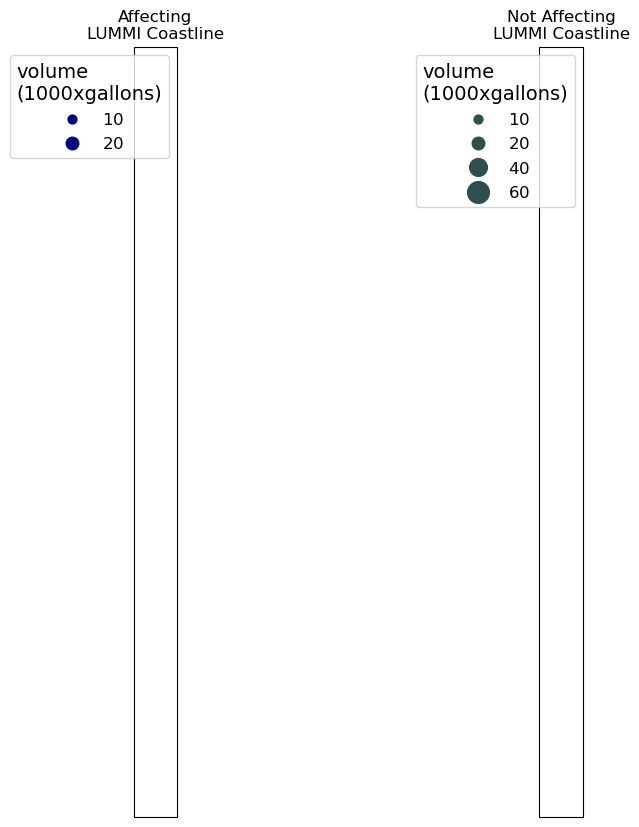

In [11]:
fs_legend = 12
fs_legend_title = 14
# scale for scatter plot marker size
ms=400
plt.rcParams['savefig.dpi']=400

for region in ['sji','lummi']:#loc_tags:#['sji','ps','lummi']:#
    # --------- Figure setup ---------
    proj_ref = crs.PlateCarree()
    lw = 1 # linewidth for regional boundary boxes
    fs = 12 #fontsize for colorbar

    # The code for this figure is a modified version of code from Ben Moore-Maley
    fig, axs = plt.subplots(1, 2, 
                  figsize=(10, 10), #(width, height)
                  subplot_kw={'projection': rotated_crs, 
                    "facecolor": "white"},
                  gridspec_kw={
                       'width_ratios': [1,1],
                       'height_ratios': [1],
                       'wspace': 0.1,
                      'hspace':-.2}
    )

    for subplot in [0,1]:
        # Make map
        extent = [-126.5, -121.2, 46.8, 51.2]
        proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
        axs[subplot].set_extent([-124, -123.75, lats.min()-0.15, lats.max()])      
        axs[subplot].add_feature(feature.GSHHSFeature(
            'full', edgecolor='k', linewidth=0.6, facecolor='lightgrey'))
        axs[subplot].add_feature(feature.NaturalEarthFeature(
            category='physical', name='rivers_lake_centerlines',
            scale='10m', facecolor='none', edgecolor='k',
        ))
        
        # Overlay region box
        domain_box = numpy.array(
            [(lons[ji], lats[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
        #c=axs[0].contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
        p=axs[subplot].add_patch(patches.Polygon(locals()[f'{region}_box'], fc='w', ec='k', alpha=0.2, lw=lw, transform=proj_ref, zorder=3))
        p=axs[subplot].add_patch(patches.Polygon(locals()[f'{region}_box'], fc='none', ec='darkred', lw=3, transform=proj_ref, zorder=3))


        # ~~~ Number of spills ~~~
        if subplot==0:
            spill_color = 'navy'
            # do coordinate conversion of (x,y)
            xynps = axs[subplot].projection.transform_points(
                crs.Geodetic(), 
                numpy.array(spillLocsByRegion[region]['lon']), 
                numpy.array(spillLocsByRegion[region]['lat']))
            # calculate histograms for number of spills and plot using pcolormesh
            s = [ms*vol/max_vol for vol in spillLocsByRegion[region]['vol']]
            scatter_transfers=axs[subplot].scatter(
                xynps[:,0], 
                xynps[:,1],
                color=spill_color,
                marker='o',
                zorder=4,
                s=s,
                alpha=0.5
            )
            # use "func" to convert values back and scale from liters to megaliters
            # see: https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
            handles, labels = scatter_transfers.legend_elements(
                prop="sizes", 
                color=spill_color, 
                num=[10, 20, 40, 60], 
                func=lambda x: max_vol*x/ms/1000,alpha=1)
            legend = axs[subplot].legend(
                handles, 
                labels, 
                loc="upper right", 
                title="volume\n(1000xgallons)",
                fontsize=fs_legend)
            plt.setp(legend.get_title(),fontsize=fs_legend_title)
            axs[subplot].set_title(f'Affecting\n{region.upper()} Coastline', fontsize=fs)
        else:
            # do coordinate conversion of (x,y)
            nospill_color = 'darkslategrey'
            xynps = axs[subplot].projection.transform_points(
                crs.Geodetic(), 
                numpy.array(no_spillLocsByRegion[region]['lon']), 
                numpy.array(no_spillLocsByRegion[region]['lat']))
             # calculate histograms for number of spills and plot using pcolormesh
            s = [ms*vol/max_vol for vol in no_spillLocsByRegion[region]['vol']]
            scatter_transfers=axs[subplot].scatter(
                xynps[:,0], 
                xynps[:,1],
                color=nospill_color,
                edgecolor=nospill_color,
                marker='o',
                zorder=4,
                s=s,
                alpha=0.5
            )
            # use "func" to convert values back and scale from liters to megaliters
            # see: https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
            handles, labels = scatter_transfers.legend_elements(
                prop="sizes", color=nospill_color, 
                num=[10, 20, 40, 60], 
                func=lambda x: max_vol*x/ms/1000,
                alpha=1)

            print(handles)
            # handles, labels = scatter_transfers.legend_elements(
            #     prop="sizes", color=nospill_color, num=4, alpha=1)
            legend = axs[subplot].legend(
                handles, 
                labels, 
                loc="upper right", 
                title="volume\n(1000xgallons)", 
                fontsize=fs_legend)
            plt.setp(legend.get_title(),fontsize=fs_legend_title)
            axs[subplot].set_title(f'Not Affecting\n{region.upper()} Coastline', fontsize=fs)
   
    plt.savefig(graphics_directory/f'Spills_vs_NoSpills_byRegion_{region}_gallons.png')
    



In [12]:
# get length of legend entries
            Nitems=5
            Nlegend_items=len(scatter_transfers.legend_elements("sizes", num=Nitems)[:][0])
            # legend_txt=[]
            # for idx,legend_item in enumerate(scatter_transfers.legend_elements("sizes", num=Nitems)[1][:]):
            #     legend_txt.append(
            #         max_vol*float(sc.legend_elements("sizes", num=Nitems)[1][idx].split("{")[1].split("}")[0])/ms)
            # handles, labels = scatter_transfers.legend_elements(
            #     prop="sizes", color=spill_color, num=Nitems, func=lambda x: max_vol*x/400,alpha=1)
            # for idx,legend_item in enumerate(scatter_transfers.legend_elements("sizes", num=[max_vol/4,max_vol/2])[1][:]):
            #     legend_txt.append(
            #         max_vol*float(sc.legend_elements("sizes", num=[max_vol/4,max_vol/2])[1][idx].split("{")[1].split("}")[0])/ms)
            

IndentationError: unexpected indent (2364808698.py, line 2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
a2 = 400*np.random.rand(N)

sc = plt.scatter(x, y, s=a2, alpha=0.5)
plt.legend(*sc.legend_elements("sizes", num=6))
plt.show()

In [ ]:
# get length of legend entries
Nlegend_items=len(sc.legend_elements("sizes", num=6)[:][0])
for idx,legend_item in enumerate(sc.legend_elements("sizes", num=6)[1][:]):
    print(float(sc.legend_elements("sizes", num=6)[1][idx].split("{")[1].split("}")[0])/400)

In [ ]:
for idx,legend_item in enumerate(sc.legend_elements("sizes", num=6)[1][:]):
    print(float(sc.legend_elements("sizes", num=6)[1][idx].split("{")[1].split("}")[0])/400)

In [ ]:
import numpy as np
import pandas as pd
N=200
M=5
x = np.random.rand(N)
y = np.random.rand(N)
a2 = 400*np.random.rand(N)

# Create the DataFrame from your randomised data and bin it using groupby.
df = pd.DataFrame(data=dict(x=x, y=y, a2=a2))
bins = np.linspace(df.a2.min(), df.a2.max(), M)
grouped = df.groupby(np.digitize(df.a2, bins))

# Create some sizes and some labels.
sizes = [50*(i+1.) for i in range(M)]
labels = ['Tiny', 'Small', 'Medium', 'Large', 'Huge']

for i, (name, group) in enumerate(grouped):
    print(name,group)


In [ ]:
numpy.digitize(spillLocsByRegion[region]['vol'], bins)

In [ ]:
for region in loc_tags:
    print(max(numpy.max(spillLocsByRegion[region]['vol']),numpy.max(no_spillLocsByRegion[region]['vol'])))

In [ ]:
fs = 20
ms = 300
fs_legend = 12
fs_legend_title = 16
import matplotlib.gridspec as gridspec

handles, labels = scatter_transfers.legend_elements(prop="sizes", color='brown', num=3, alpha=1)
legend = axs[2].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
plt.setp(legend.get_title(),fontsize=fs_legend_title)
axs[2].set_title('oil transfer volumes', fontsize=fs)